# 波士顿房价预测

## Step 1: 查看数据集

In [2]:
import numpy as np
import pandas as pd

#### 读入数据

* 数据保存在input文件夹中

In [3]:
train_df = pd.read_csv('../input/train.csv', index_col=0)
test_df = pd.read_csv('../input/test.csv', index_col=0)

#### 检视源数据

In [4]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


可以观察各个属性的数据特征，是否有缺失值？是否需要将Y/N或性别等数据类型转换为数字？

## Step 2: 合并数据
用DF进行数据预处理的时候，把test、train的数据一起处理了，比较方便。等所有的需要的预处理进行完之后，我们再把他们分隔开。
SalePrice作为我们的训练目标，只会出现在训练集中，不会在测试集中。所以，把*SalePrice*这一列取出。先作图观察SalePrice这一列数据：

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014D8D037668>,
      dtype=object)

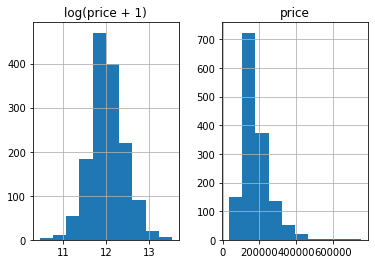

In [5]:
%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()

可见，label本身并不平滑。为了我们分类器的学习更加准确，我们会首先把label给“平滑化”（正态化）

这里使用log1p, 也就是 log(x+1)进行平滑。

如果这里把数据都给平滑化了，那么最后算结果的时候，要把预测到的平滑数据给变回去。

log1p()就需要expm1()变回去

In [6]:
y_train = np.log1p(train_df.pop('SalePrice'))

然后把剩下的部分合并起来

In [7]:
all_df = pd.concat((train_df, test_df), axis=0)

此刻，可以看到all_df就是合在一起的DF

In [8]:
all_df.shape

(2919, 79)

而*y_train*则是*SalePrice*那一列

In [9]:
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

## Step 3: 预处理

类似特征工程，把不方便处理的数据给统一。

#### 正确化变量属性

①*MSSubClass* 的值其实是一个category，但使用DF的时候，这类数字符号会被默认记成数字。这就很有误导性，需要把它变回成*string*

In [10]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [11]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

变成*str*以后，可以统计一下每个类别出现的次数

In [12]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

#### 把category的变量转变成numerical表达形式

当使用numerical来表达categorical的时候，数字本身有大小的含义，可能会给之后的模型学习带来麻烦。于是可以用One-Hot的方法来表达category。

pandas自带的get_dummies方法，可以做到One-Hot。

In [13]:
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


此刻*MSSubClass*被我们分成了12个column，每一个代表一个category。是就是1，不是就是0。

同理，把所有的category数据，都进行One-Hot

In [14]:
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


#### 处理好numerical变量

就算是numerical的变量，也还会有一些小问题。比如，有一些数据是缺失的：

In [15]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

可以看到，缺失最多的column是LotFrontage

在这里，用平均值来填满这些空缺。

In [16]:
mean_cols = all_dummy_df.mean()
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [17]:
all_dummy_df = all_dummy_df.fillna(mean_cols)

检查是否所有的空缺都被填上平均值

In [18]:
all_dummy_df.isnull().sum().sum()

0

#### 标准化numerical数据

把源数据给放在一个标准分布内。不让数据间的差距太大。

先显示是numerical的属性：

In [19]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

计算标准分布：(X-X')/s

让我们的数据点更平滑，更便于计算。

In [20]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

## Step 4: 建立模型

#### 把数据集分回 训练/测试集

In [21]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

In [22]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

把DF转化成Numpy Array，符合Sklearn

In [23]:
X_train = dummy_train_df.values
X_test = dummy_test_df.values

用Sklearn自带的cross validation方法来测试模型

#### Random Forest 随机森林

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [25]:
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

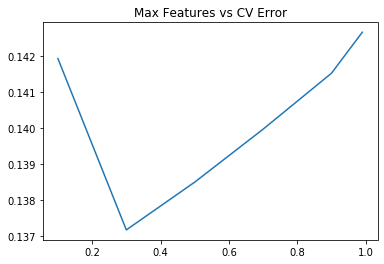

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error");

用随机森林的最优值达到了0.137

#### Decision Tree 决策树

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [29]:
max_depths = [2,4,6,8,10,12,14,16,18,20]
test_scores = []
for max_depth in max_depths:
    regressor = DecisionTreeRegressor(random_state=0,max_depth=max_depth)
    test_score = np.sqrt(-cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

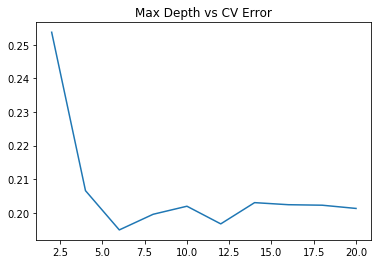

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_depths, test_scores)
plt.title("Max Depth vs CV Error");

可以看出，随机森林的结果目前好于决策树的结果